# Análise Experimental da Simulação

Este notebook realiza uma análise experimental do sistema de escalonamento logístico, avaliando o impacto de diferentes parâmetros no desempenho da simulação.

In [1]:
import subprocess
import time
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Garante que o diretório para salvar os gráficos exista
if not os.path.exists('graficos'):
    os.makedirs('graficos')

## Configuração e Funções Auxiliares

In [2]:
# --- Configuration ---
EXECUTABLE = './bin/tp2.out'
TEMP_INPUT_FILE = 'temp_input.txt'

# --- Baseline Parameters ---
BASE_CAPACIDADE_TRANSPORTE = 2
BASE_LATENCIA_TRANSPORTE = 20
BASE_INTERVALO_TRANSPORTE = 100
BASE_CUSTO_REMOCAO = 1
BASE_NUM_ARMAZENS = 4
BASE_NUM_PACOTES = 50

# --- Helper Functions ---
def generate_input_file(params):
    """Generates a temporary input file for the simulation."""
    with open(TEMP_INPUT_FILE, 'w') as f:
        f.write(f"{params['capacidade_transporte']}\n")
        f.write(f"{params['latencia_transporte']}\n")
        f.write(f"{params['intervalo_transporte']}\n")
        f.write(f"{params['custo_remocao']}\n")
        f.write(f"{params['num_armazens']}\n")

        # Generate a simple connected graph for the adjacency matrix
        for i in range(params['num_armazens']):
            for j in range(params['num_armazens']):
                is_connected = 1 if abs(i - j) == 1 or (i == 0 and j == params['num_armazens'] - 1) or (j == 0 and i == params['num_armazens'] - 1) else 0
                if i == j: is_connected = 0
                f.write(f"{'1' if is_connected else '0'} ")
            f.write('\n')

        f.write(f"{params['num_pacotes']}\n")
        # Generate random packages
        for i in range(params['num_pacotes']):
            tempo = random.randint(1, 200)
            origem = random.randint(0, params['num_armazens'] - 1)
            destino = random.randint(0, params['num_armazens'] - 1)
            while origem == destino:
                destino = random.randint(0, params['num_armazens'] - 1)
            f.write(f"{tempo} pac {i+1} org {origem} dst {destino}\n")

def run_simulation():
    """Runs the simulation and returns execution time and rearmazenamentos count."""
    result = subprocess.run([EXECUTABLE, TEMP_INPUT_FILE], capture_output=True, text=True)

    if result.returncode != 0:
        print("Error running simulation:")
        print(result.stderr)
        return 0, 0
    
    execution_time = result.stdout.splitlines()[-1].split()[0]
    rearmazenamentos = result.stdout.count('rearmazenado')
    return execution_time, rearmazenamentos

def plot_single_metric(df, x_col, y_col, title, x_label, y_label, filename):
    """Plots a single metric and saves the figure."""
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.savefig(f'graficos/{filename}')
    plt.show()

## 1. Análise do Número de Armazéns

In [3]:
results = []
num_armazens_list = np.linspace(4, 100, num=20, dtype=int).tolist()  # Ensure we have a range of values

for num in num_armazens_list:
    params = {
        'capacidade_transporte': BASE_CAPACIDADE_TRANSPORTE,
        'latencia_transporte': BASE_LATENCIA_TRANSPORTE,
        'intervalo_transporte': BASE_INTERVALO_TRANSPORTE,
        'custo_remocao': BASE_CUSTO_REMOCAO,
        'num_armazens': num,
        'num_pacotes': BASE_NUM_PACOTES * (num // 4)
    }
    generate_input_file(params)
    exec_time, rearmz = run_simulation()
    results.append({'Armazens': num, 'Tempo (s)': exec_time, 'Rearmazenamentos': rearmz})

df_armazens = pd.DataFrame(results)
print("Resultados: Análise do Número de Armazéns")
display(df_armazens)

Resultados: Análise do Número de Armazéns


,Armazens,Tempo (s),Rearmazenamentos
0,4,0000912,77
1,9,0001240,276
2,14,0001652,580
3,19,0002009,916
4,24,0002833,2309
5,29,0003209,3161
6,34,0003759,4102
7,39,0004108,4625
8,44,0005064,7326
9,49,0005203,8658


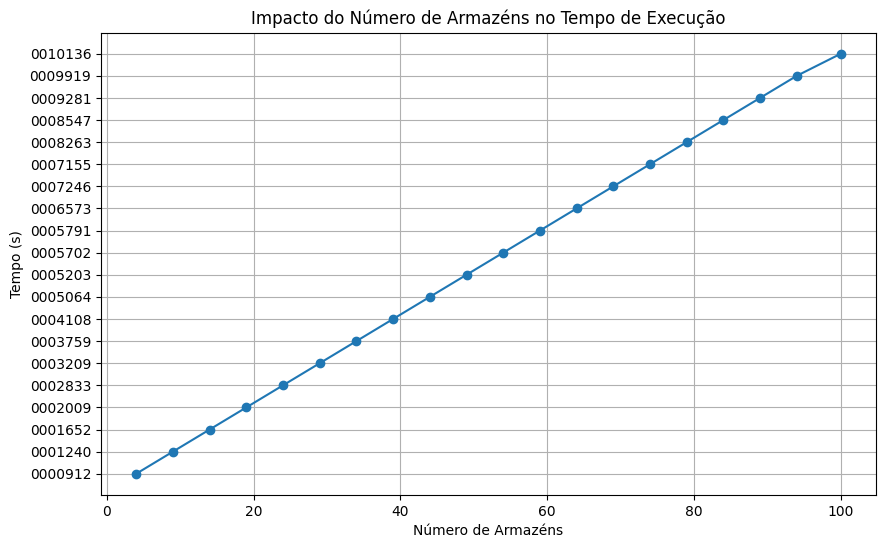

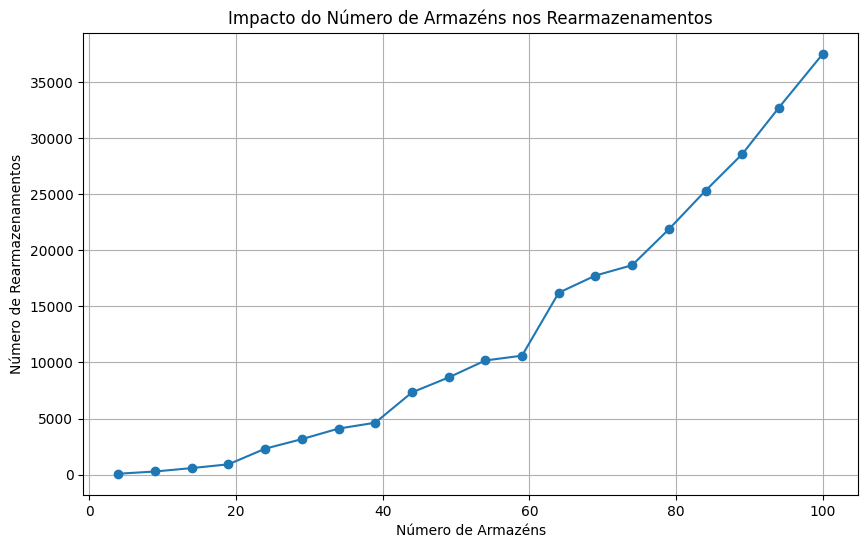

In [4]:
# Gráfico para Tempo de Execução
plot_single_metric(df_armazens, 'Armazens', 'Tempo (s)', 
                   'Impacto do Número de Armazéns no Tempo de Execução', 
                   'Número de Armazéns', 'Tempo (s)', 'armazens_tempo.png')

# Gráfico para Rearmazenamentos
plot_single_metric(df_armazens, 'Armazens', 'Rearmazenamentos', 
                   'Impacto do Número de Armazéns nos Rearmazenamentos', 
                   'Número de Armazéns', 'Número de Rearmazenamentos', 'armazens_rearmazenamentos.png')

## 2. Análise do Número de Pacotes

In [14]:
results = []
num_pacotes_list = [num for num in range(1,BASE_NUM_PACOTES * (BASE_NUM_ARMAZENS // 4), 2) if num <= BASE_NUM_PACOTES * (BASE_NUM_ARMAZENS // 4)]  # Limit to max packages based on armazens

for num in num_pacotes_list:
    params = {
        'capacidade_transporte': BASE_CAPACIDADE_TRANSPORTE,
        'latencia_transporte': BASE_LATENCIA_TRANSPORTE,
        'intervalo_transporte': BASE_INTERVALO_TRANSPORTE,
        'custo_remocao': BASE_CUSTO_REMOCAO,
        'num_armazens': BASE_NUM_ARMAZENS,
        'num_pacotes': num
    }
    generate_input_file(params)
    exec_time, rearmz = run_simulation()
    results.append({'Pacotes': num, 'Tempo (s)': exec_time, 'Rearmazenamentos': rearmz})

df_pacotes = pd.DataFrame(results)
print("Resultados: Análise do Número de Pacotes")
display(df_pacotes)

Resultados: Análise do Número de Pacotes


,Pacotes,Tempo (s),Rearmazenamentos
0,1,0000216,0
1,3,0000262,0
2,5,0000246,0
3,7,0000340,0
4,9,0000360,1
5,11,0000388,1
6,13,0000461,7
7,15,0000438,1
8,17,0000476,5
9,19,0000713,13


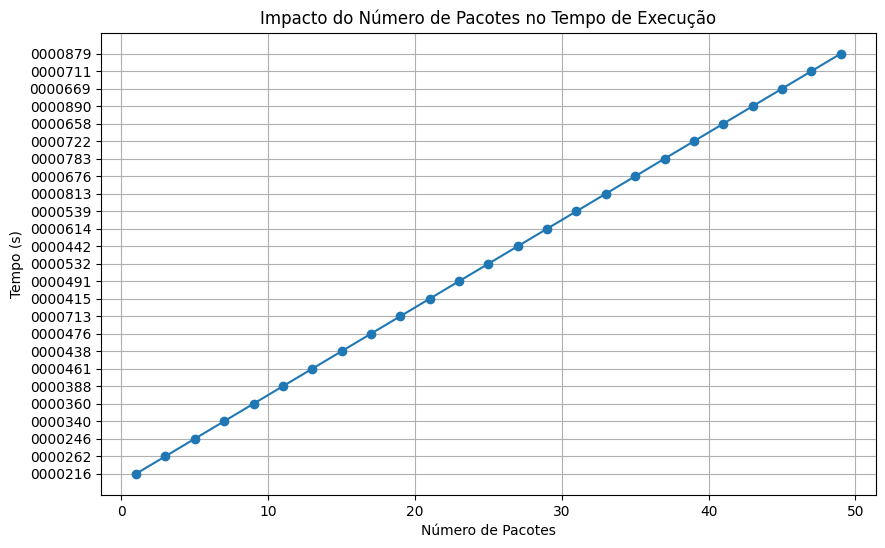

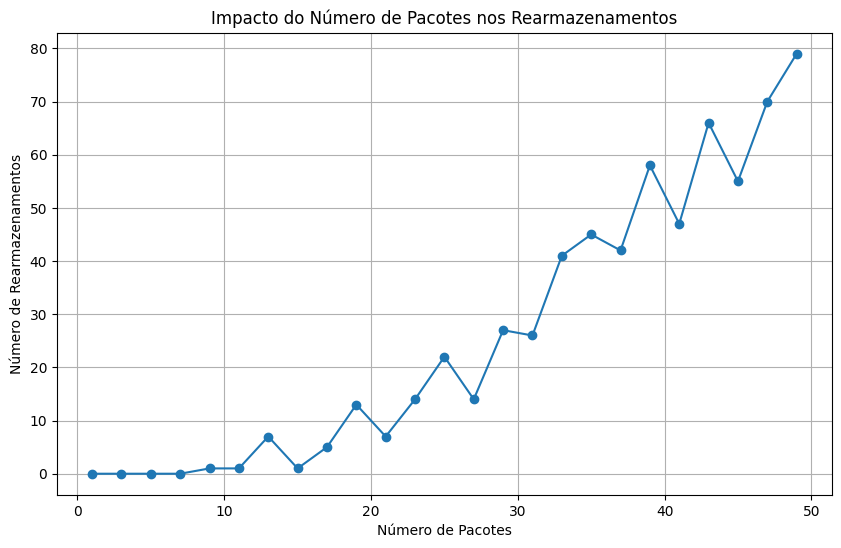

In [15]:
# Gráfico para Tempo de Execução
plot_single_metric(df_pacotes, 'Pacotes', 'Tempo (s)', 
                   'Impacto do Número de Pacotes no Tempo de Execução', 
                   'Número de Pacotes', 'Tempo (s)', 'pacotes_tempo.png')

# Gráfico para Rearmazenamentos
plot_single_metric(df_pacotes, 'Pacotes', 'Rearmazenamentos', 
                   'Impacto do Número de Pacotes nos Rearmazenamentos', 
                   'Número de Pacotes', 'Número de Rearmazenamentos', 'pacotes_rearmazenamentos.png')

## 3. Análise da Contenção por Transporte

### 3.1. Variação da Capacidade de Transporte

In [16]:
results = []
capacidade_list = [cap for cap in range(1, 100, 5)]  # Limit to max capacity

for cap in capacidade_list:
    params = {
        'capacidade_transporte': cap,
        'latencia_transporte': BASE_LATENCIA_TRANSPORTE,
        'intervalo_transporte': BASE_INTERVALO_TRANSPORTE,
        'custo_remocao': BASE_CUSTO_REMOCAO,
        'num_armazens': BASE_NUM_ARMAZENS,
        'num_pacotes': BASE_NUM_PACOTES
    }
    generate_input_file(params)
    exec_time, rearmz = run_simulation()
    results.append({'Capacidade': cap, 'Tempo (s)': exec_time, 'Rearmazenamentos': rearmz})

df_capacidade = pd.DataFrame(results)
print("Resultados: Análise da Capacidade de Transporte")
display(df_capacidade)

Resultados: Análise da Capacidade de Transporte


,Capacidade,Tempo (s),Rearmazenamentos
0,1,0001469,221
1,6,0000442,9
2,11,0000381,0
3,16,0000356,0
4,21,0000403,0
5,26,0000316,0
6,31,0000382,0
7,36,0000414,0
8,41,0000415,0
9,46,0000379,0


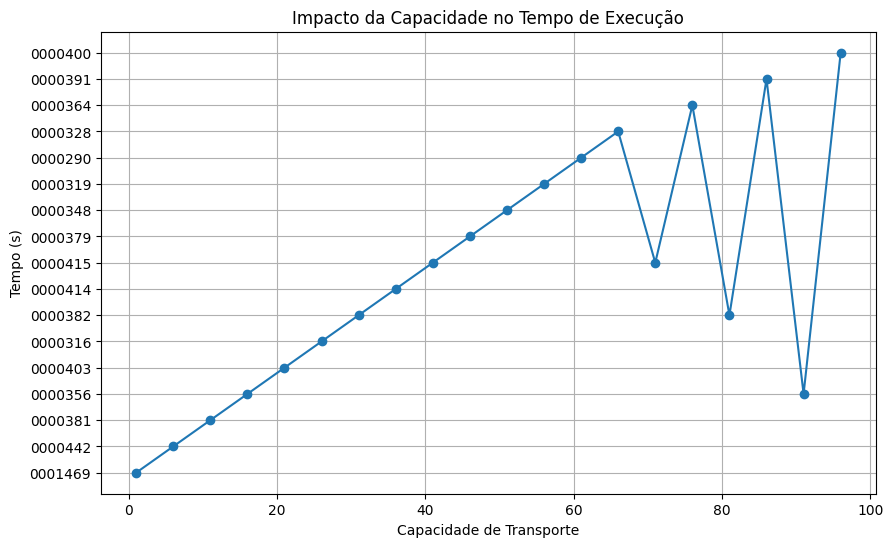

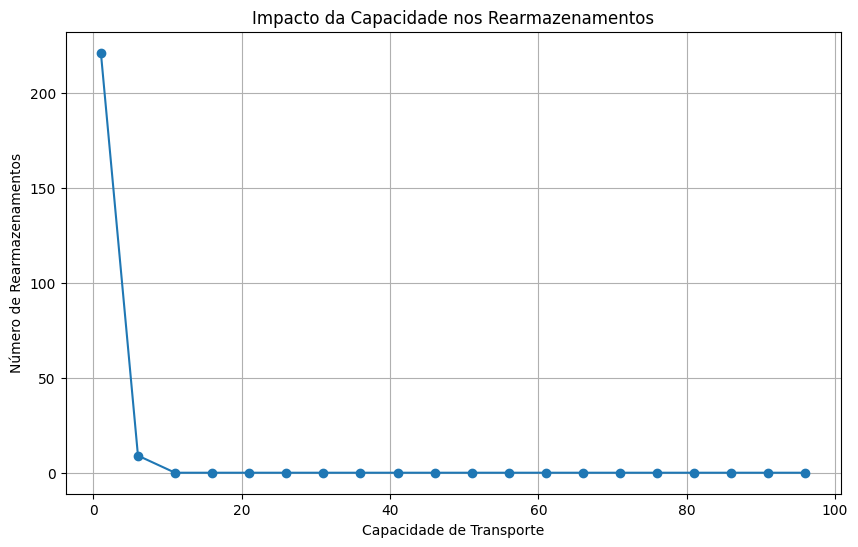

In [17]:
# Gráfico para Tempo de Execução
plot_single_metric(df_capacidade, 'Capacidade', 'Tempo (s)', 
                   'Impacto da Capacidade no Tempo de Execução', 
                   'Capacidade de Transporte', 'Tempo (s)', 'capacidade_tempo.png')

# Gráfico para Rearmazenamentos
plot_single_metric(df_capacidade, 'Capacidade', 'Rearmazenamentos', 
                   'Impacto da Capacidade nos Rearmazenamentos', 
                   'Capacidade de Transporte', 'Número de Rearmazenamentos', 'capacidade_rearmazenamentos.png')

### 3.2. Variação do Intervalo de Transporte

In [18]:
results = []
intervalo_list = [num for num in range(BASE_INTERVALO_TRANSPORTE, 200, 5)]  # Include the base interval

for interv in intervalo_list:
    params = {
        'capacidade_transporte': BASE_CAPACIDADE_TRANSPORTE,
        'latencia_transporte': BASE_LATENCIA_TRANSPORTE,
        'intervalo_transporte': interv,
        'custo_remocao': BASE_CUSTO_REMOCAO,
        'num_armazens': BASE_NUM_ARMAZENS,
        'num_pacotes': BASE_NUM_PACOTES
    }
    generate_input_file(params)
    exec_time, rearmz = run_simulation()
    results.append({'Intervalo': interv, 'Tempo (s)': exec_time, 'Rearmazenamentos': rearmz})

df_intervalo = pd.DataFrame(results)
print("Resultados: Análise do Intervalo de Transporte")
display(df_intervalo)

Resultados: Análise do Intervalo de Transporte


,Intervalo,Tempo (s),Rearmazenamentos
0,100,0000878,95
1,105,0001084,107
2,110,0000860,82
3,115,0000893,82
4,120,0001041,91
5,125,0001187,119
6,130,0001172,99
7,135,0000978,79
8,140,0001334,102
9,145,0000750,50


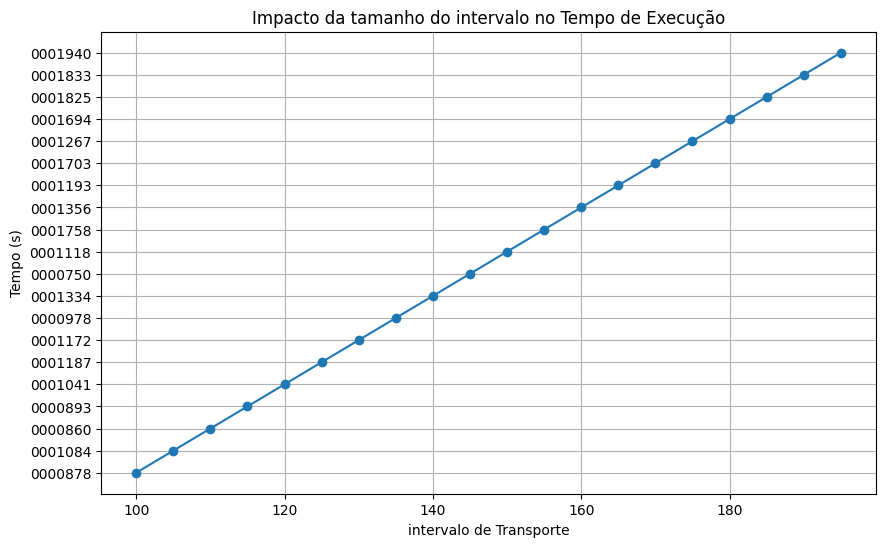

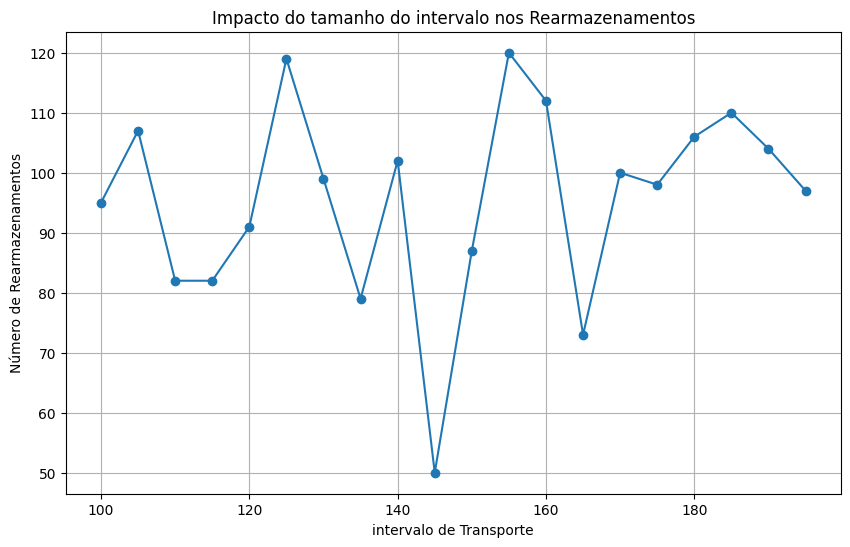

In [19]:
# Gráfico para Tempo de Execução
plot_single_metric(df_intervalo, 'Intervalo', 'Tempo (s)', 
                   'Impacto da tamanho do intervalo no Tempo de Execução', 
                   'intervalo de Transporte', 'Tempo (s)', 'intervalo_tempo.png')

# Gráfico para Rearmazenamentos
plot_single_metric(df_intervalo, 'Intervalo', 'Rearmazenamentos', 
                   'Impacto do tamanho do intervalo nos Rearmazenamentos', 
                   'intervalo de Transporte', 'Número de Rearmazenamentos', 'intervalo_rearmazenamentos.png')

### 3.3. Variação da Latência de Transporte

In [20]:
results = []
latencia_list = [lat for lat in range(BASE_LATENCIA_TRANSPORTE, 50, 1)]  # Include the base latency

for lat in latencia_list:
    params = {
        'capacidade_transporte': BASE_CAPACIDADE_TRANSPORTE,
        'latencia_transporte': lat,
        'intervalo_transporte': BASE_INTERVALO_TRANSPORTE,
        'custo_remocao': BASE_CUSTO_REMOCAO,
        'num_armazens': BASE_NUM_ARMAZENS,
        'num_pacotes': BASE_NUM_PACOTES
    }
    generate_input_file(params)
    exec_time, rearmz = run_simulation()
    results.append({'Latencia': lat, 'Tempo (s)': exec_time, 'Rearmazenamentos': rearmz})

df_latencia = pd.DataFrame(results)
print("Resultados: Análise da Latência de Transporte")
display(df_latencia)

Resultados: Análise da Latência de Transporte


,Latencia,Tempo (s),Rearmazenamentos
0,20,0001099,109
1,21,0000801,83
2,22,0000993,111
3,23,0000875,88
4,24,0000682,63
5,25,0000751,75
6,26,0001069,125
7,27,0000721,76
8,28,0000911,93
9,29,0000670,62


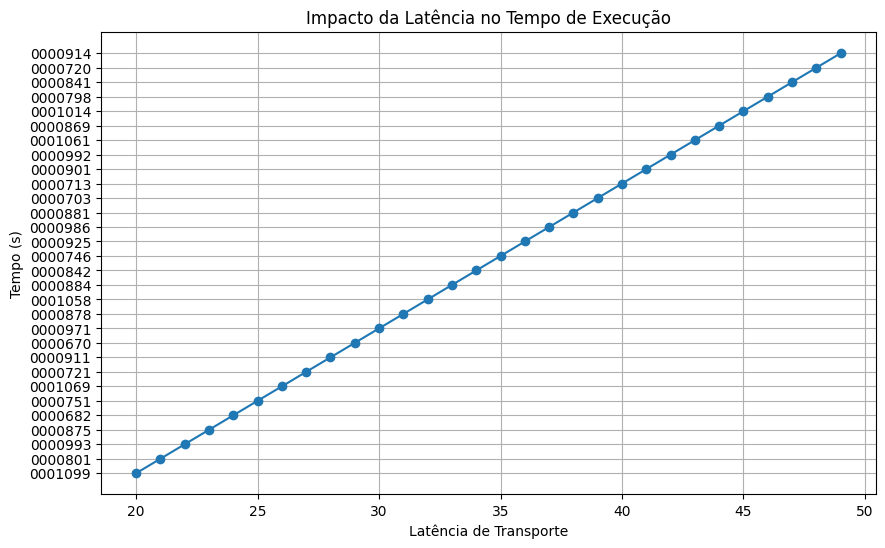

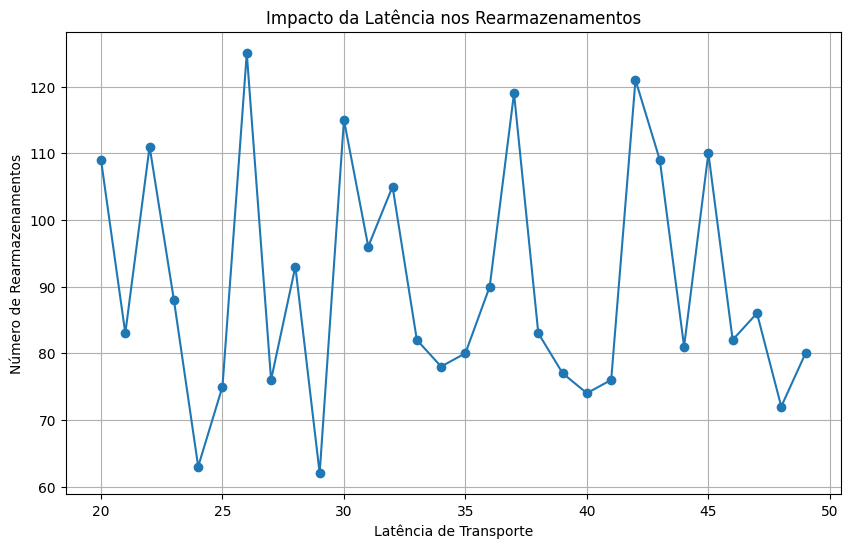

In [21]:
# Gráfico para Tempo de Execução
plot_single_metric(df_latencia, 'Latencia', 'Tempo (s)', 
                   'Impacto da Latência no Tempo de Execução', 
                   'Latência de Transporte', 'Tempo (s)', 'latencia_tempo.png')

# Gráfico para Rearmazenamentos
plot_single_metric(df_latencia, 'Latencia', 'Rearmazenamentos', 
                   'Impacto da Latência nos Rearmazenamentos', 
                   'Latência de Transporte', 'Número de Rearmazenamentos', 'latencia_rearmazenamentos.png')

## Limpeza

In [22]:
# Clean up the temporary file
if os.path.exists(TEMP_INPUT_FILE):
    os.remove(TEMP_INPUT_FILE)